In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
# import tqdm.auto as tqdm
from tqdm import tqdm

from scipy.linalg import block_diag
from scipy.special import binom

from itertools import combinations


from numpy.typing import ArrayLike

### Remarks

* [wrapped normal distributions](https://mpmath.org/doc/0.19/functions/elliptic.html#jacobi-theta-functions)



### Deformation Space

Recall that the following three spaces are all diffeomorphic 

$$Q = \{ z \in \mathbb{C}^{n+1} \mid \sum_k z_k^2 = 1 \}$$

$$TS^n = \{ (x,y) \mid x \in S^n, \langle x , y \rangle = 0\}$$

$$S^n \times S^n / \Delta = \{(u,v) \mid u,v \in S^n, u \neq v \}$$

The diffeomorphism are given by 

$$\Psi \colon TS^n \to Q \quad , \quad (x,y) \mapsto (x \sqrt{1 + \lVert y \rVert^2} + i y)$$

and 

$$\Phi \colon S^n \times S^n / \Delta \to TS^n \quad , \quad (u,v) \mapsto \left(u, \frac{v - \langle u, v\rangle u}{1 - \langle u, v\rangle}\right)$$

### The Model

For $z,w$ in $\mathbb{CP}^n$: 

$$S(z,w) = -\beta \sum_{a,b} z_a \bar z_b w_b \bar w_a$$

Now, forget about the $U(1)$ invariance (can be integrated out since compact) and fix the non-compact part of the $\mathbb{C}^*$ gauge group via 

$$\delta( \lvert z \rvert^2 - 1)  \delta( \lvert w \rvert^2 - 1)$$ 

with 

$$\lvert z \rvert^2 = \sum_a \lvert z_a \rvert^2$$

Rewrite it in real variables: let $z_a = x_a + i y_a$, $w_a = u_a + i v_a$ and define _real_ vectors $Z = (\dots,x_a,y_a,\dots)$ and $W = (\dots,u_a,v_a,\dots)$ with $\lVert Z \rVert^2 = 1$ and likewise for $W$.

Define $h = id + J$ where $J = diag(\sigma_y, \dots, \sigma_y)$ where 

$$\sigma_y = \begin{pmatrix} 0 & -i \\ i & 0\end{pmatrix}$$

Then 

$$S(Z,W) = \beta \langle Z , T W \rangle \langle W , T Z \rangle$$

where $\langle \dots \rangle$ is the standard inner product in $\mathbb{R}^{2n+2}$.


In [ ]:
# DIFFEOMORPHISMS TS^n <-> Q <-> S^n x S^n / Delta

def Psi(p): # TS^n -> Q
    x, y = p # unpack point (into base point x, tangent vector y)

    z = x*np.sqrt(1 + np.inner(y,y)) + y*1j

    return z

def invPsi(z): # Q -> TS^n
    re, im = (z.real,z.imag) # seperate into re and im part
    
    x = re / np.sqrt(1 + np.inner(im,im))
    y = im
    
    return (x,y)

def Phi(p): # S^n x S^n / Delta -> TS^n
    u, v = p # unpack p

    x = u # base point
    y = (v - np.inner(u,v)*u) / (1 - np.inner(u,v)) # tangent vector 

    return (x,y)

def invPhi(p): # TS^n -> S^n x S^n / Delta
    x,y = p # unpack base point, tangent vector

    u = x
    v = (x*(np.inner(y,y) - 1) + 2*y ) / (np.inner(y,y) + 1)

    return u, v


# HERMITIAN INNER PRODUCT 

def h(n:int,Z:np.ndarray,W:np.ndarray) -> np.ndarray:
    """ 
    Quadratic form h used in action functional 

    :param n: complex dimension of CP^n
    :type n: int

    :param Z: (samples,2n + 2,1) real column vector 
    :type Z: np.ndarray

    :param W: (samples,2n + 2,1) real column vector 
    :type W: np.ndarray

    :returns: h(Z,W) for each sample
    :rtype: np.ndarray
    """
    id = np.eye(2*(n + 1))

    sigma_y = np.array([[0,-1j],[1j,0]])

    J = block_diag(*[sigma_y for _ in range(n+1)])

    # result = np.inner(Z.flatten(), ((id + J) @ W).flatten())
    result = ( Z.transpose(0,-1,1) @ ( (id + J) @ W) ).flatten()

    return result

def Scmplx(z:complex,w:complex,beta:float) -> float:
    return  - beta * np.inner(z,w.conjugate()) * np.inner(w, z.conjugate())

# TOY MODEL ACTION FUNCTIONAL

def S(n:int, Z:np.ndarray,W:np.ndarray,beta:float) -> float: # action on real variables
    return  - beta * h(n,Z,W) * h(n,W,Z)

# 2X2 ROTATION MATRIX FOR SAMPLING SPHERE
def R(t:float) -> np.ndarray:
    """
    2x2 roation matrix 

    :param t: rotation angle
    :type t: float

    :returns: rotation matrix np.array([[cos(t),-sin(t)],[sin(t),cos(t)]])
    :rtype: np.ndarray
    """

    c = np.cos(t)
    s = np.sin(t)

    return np.array([[c,-s],[s,c]])

# LINEAR ALGEBRA

def inner(a,X): # inner product <X,a>
    """
    shape X,a = (samples, 2n + 2, 1)
    """

    assert X.shape == a.shape
    assert len(X.shape) == 3
    assert X.shape[-1] == 1

    return X.transpose(0,-1,1) @ a

def outer(a,X): # outer product 
    """
    shape X,a = (samples, 2n + 2, 1)
    """

    assert X.shape == a.shape
    assert len(X.shape) == 3
    assert X.shape[-1] == 1

    return a * X.transpose(0,-1,1) 

def proj(a,X): # projection a ortho X where X has norm 1

    # would like to assert that X has norm 1
    # assert np.abs(1 - np.linalg.norm(X)) <= 1e-8

    inner_Xa = inner(X,a)
    
    return (a - inner_Xa * X) 

# def M(a,X):
#     """
#     shape X,a = (samples, 2n + 2, 1)
#     """

#     id = np.eye(X.shape[1])

#     inner_Xa = inner(X,a)

#     numerator = outer(a,a-X) - id * inner_Xa * ( 1 -  inner_Xa) 

#     denom = (1 - inner_Xa)**2

#     return numerator / denom

# def proj(a,X): # projection a ortho X

#     inner_Xa = inner(X,a)
    
#     return (a - inner_Xa * X) / (1 - inner_Xa)

# JACOBIAN TOY MODEL

def M(a,X):
    """
    shape X,a = (samples, 2n + 2, 1)
    """

    assert X.shape == a.shape
    assert len(X.shape) == 3
    assert X.shape[-1] == 1

    id = np.eye(X.shape[1])

    inner_Xa = inner(X,a)

    return - outer(a,X) - id * inner_Xa 


def Jac(a,X):

    Y = proj(a,X)

    lam = np.sqrt(1 + inner(Y,Y)) # shape (samples,1,1)

    id = np.eye(X.shape[1])

    MM = M(a,X)

    J = id*lam + outer( (MM @ Y), X) / lam + 1j*MM

    det = np.linalg.det(J) # shape (samples,)

    return det / lam.flatten()**2 # IS THIS CORRECT?

# COMPLEXIFICATION 

def tildeZ(a,X): # paramerisation of (analytical continuation of) Z

    Y = proj(a,X)

    return X * np.sqrt(1 + inner(Y,Y)) + 1j*Y

# MCMC

def sweep_sphere(phi:list,pairs:list,f) -> int:  
    """
    sweeping the sphere

    :param n: complex dimension CP^n
    :type n: int
    """

    alpha = 0 # number accepted

    # LOOP OVER COMPONENTS 
    for pair in pairs:
        a,b = pair # unpack indices
        phi_old = phi[-1] # current state 

        # SAMPLE 2x2 ROTATION ANGLE
        # theta = np.random.vonmises(mu=0.0,kappa=2)
        theta = np.random.normal(loc=0,scale=1)

        # ROTATE COMPONENT
        v = np.array([phi_old[a],phi_old[b]])
        vnew = R(theta) @ v

        # PROPOSE NEW STATE
        phi_new = phi_old.copy()
 
        phi_new[a] = vnew[0]
        phi_new[b] = vnew[1]
    
        # ACCEPTENCE PROBABILITIES
        A = np.minimum(1, f(phi_new[np.newaxis,:,:]) / (f(phi_old[np.newaxis,:,:])) ) # newaxis since f takes list of vectors: shape = (smaples,2n+2,1)

        # CHECK IF ACCEPTED
        p = np.random.uniform(low=0,high=1) # draw vector of uniform rnds
        
        if p <= A : # accept if p < A
            phi.append(phi_new)
            alpha += 1
        else:
            phi.append(phi_old)

    return alpha / len(pairs)


def MCMC_toy(n:int, Z0:complex,W0:complex,beta:float,N_steps:int,burnin:int,k:int) -> tuple[np.ndarray,float,np.ndarray]:
    """
    :param n: complex dimension CP^n 
    :type n: int
    """

    N = 2*n + 2 # real dimension (before quotient by C^*)
    pairs = list(combinations(np.arange(N),2)) # indices of pairs to rotate

    # SETUP
    Z = [Z0] 
    W = [W0]

    alpha = 0 # number accepted

    expSw = lambda z: np.exp( -S(n,z,W[-1][np.newaxis,:,:],beta) ) # w fixed
    expSz = lambda w: np.exp( -S(n,Z[-1][np.newaxis,:,:],w,beta) ) # z fixed

    for _ in tqdm(range(N_steps)): # tqdm for progress bar

        alpha += sweep_sphere(phi=Z,pairs=pairs,f=expSw) 
        alpha += sweep_sphere(phi=W,pairs=pairs,f=expSz)
       
    samples_Z, samples_W = (np.array(Z)[burnin::k], np.array(W)[burnin::k])

    acception_rate = alpha / (2*N_steps) 

    return (samples_Z, samples_W, acception_rate)



## Undeformed Path Integral

In [ ]:
n = 2

# INITIAL POINTS ON SPHERE
Z0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
Z0 /= np.linalg.norm(Z0)

W0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
W0 /= np.linalg.norm(W0)

N_steps = 10_000

t0 = time.time()

obs = []

Nbeta = 10

for beta in range(1,Nbeta):

    Z_samples, W_samples, alpha = MCMC_toy(n=n,Z0=Z0,W0=W0,beta=beta,N_steps=N_steps,burnin=200,k=5)
    obs.append(- S(n,Z_samples,W_samples,beta).real.mean()/beta)

    print(f'{beta}/{Nbeta}',end='\r')


print(f'running time: {time.time() - t0:.2f}s')


100%|██████████| 10000/10000 [00:25<00:00, 395.18it/s]


100%|██████████| 10000/10000 [00:25<00:00, 399.14it/s]


100%|██████████| 10000/10000 [00:26<00:00, 384.43it/s]


100%|██████████| 10000/10000 [00:26<00:00, 375.74it/s]


100%|██████████| 10000/10000 [00:26<00:00, 377.99it/s]


100%|██████████| 10000/10000 [00:26<00:00, 377.05it/s]


100%|██████████| 10000/10000 [00:26<00:00, 381.66it/s]


100%|██████████| 10000/10000 [00:25<00:00, 387.43it/s]


100%|██████████| 10000/10000 [00:26<00:00, 378.49it/s]


running time: 235.13s


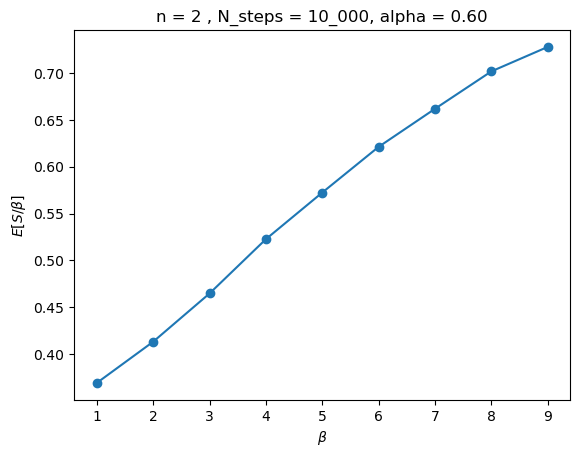

In [5]:
beta = range(1,Nbeta)
plt.plot(beta,obs,'o-')
plt.xlabel(f'$\\beta$')
plt.ylabel(f'$E[S / \\beta]$')
plt.title(f'{n = } , {N_steps = :_d}, {alpha = :.2f}');

## Deformation 

Idea: 

1. deform $S^{2n + 1} \to Q$ via $Z \to \tilde Z = Z + i \zeta_a(Z)$  


2. parametrize $Q$ via $TS^{2n+1}$:

   $$Q \ni \tilde Z(X) = X \sqrt{1 + \lVert Y_a(X) \rVert^2} + i Y_a(X)$$

   where $X \in S^{2n +1 }$ and 
   
   $$Y(X,a) = \frac{a - \langle a, X \rangle X}{1 - \langle a, X \rangle} \in T_X S^{2n + 1} \quad , \quad a \in \mathbb{R}^{2n + 2}$$

3. compute 

   $$\langle \mathcal{O}(Z) \rangle _Q = \langle \det J(X) \mathcal{O}(\tilde Z(X)) e^{- (S(\tilde Z(X)) - S(X))}\rangle _{e^{-S(X)}}$$



To do:

1. choose $a \in \mathbb{R}^{2n + 1}$ fixed constant

2. compute $Y_a(X)$ 

3. compute $\lambda(a,X) = \sqrt{1 + \lVert Y_a(X) \rVert^2}$

4. compute $J_{ij} = \lambda \delta_{ij} + \frac{(M Y)_i X_j}{\lambda} + i M_{ij}$ where

$$M_{ij} = \partial_{X_i}(Y_a(X))_j = \frac{a_i(a_j - X_j) - \delta_{ij} \langle a, X\rangle (1 - \langle a, X\rangle )}{(1 - \langle a, X\rangle)^2}$$



In [ ]:
n = 2

# INITIAL POINTS ON SPHERE
X0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
X0 /= np.linalg.norm(X0)

W0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
W0 /= np.linalg.norm(W0)

N_steps = 1_000

t0 = time.time()

beta = 1

X_samples, W_samples, alpha = MCMC_toy(n=n,Z0=X0,W0=W0,beta=beta,N_steps=N_steps,burnin=100,k=3)

a = 0.1*np.ones_like(X_samples)

tildeZ_samples = tildeZ(a,X_samples)

obs = Jac(a,X_samples) * np.exp( - ( S(n,tildeZ_samples,W_samples,beta) - S(n,X_samples,W_samples,beta) ) )

print(f'running time: {time.time() - t0:.2f}s\n')

print(f'{obs.mean() = } \n')
print(f'{obs.std() / np.sqrt(len(X_samples)) = }')

running time: 2.12s

obs.mean() = (0.9892719472159569+0.017389351334043734j) 

obs.std() / np.sqrt(len(X_samples)) = 0.011309764779520863


## Tests

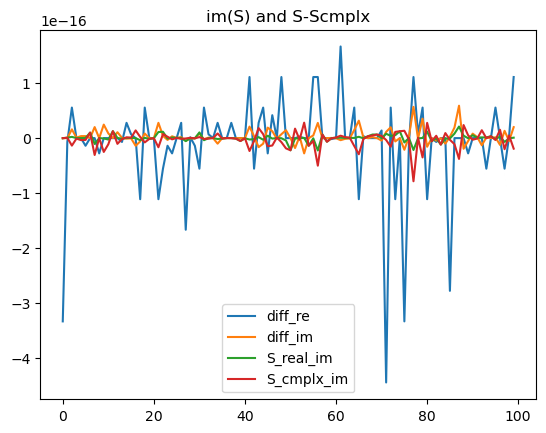

In [36]:
# TESTING S : REAL VS CMPLX

# REAL SETUP
n = 3 # complex dimension of CP^n

diff_re, diff_im, S_real_im, S_cmplx_im = [], [], [], []

for i in range(100):
    Z = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
    Z/= np.linalg.norm(Z)

    W = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
    W /= np.linalg.norm(W)


    # COMPARISON WITH COMPLEX ACTION
    reZ = Z[0::2]
    imZ = Z[1::2]

    reW = W[0::2]
    imW = W[1::2]

    z = np.array([a + b*1j for a,b in zip(reZ,imZ)])
    w = np.array([a + b*1j for a,b in zip(reW,imW)])

    # DIM NEEDED FOR S (samples,2n+2,1)
    Z = Z[np.newaxis,:,:]
    W = W[np.newaxis,:,:]

    # print(f'{S(n,Z,W,beta=1) = }')
    # print(f'{Scmplx(z.flatten(),w.flatten(),beta=1) = }')
    diff_re.append((S(n,Z,W,beta=1) - Scmplx(z.flatten(),w.flatten(),beta=1)).real)
    diff_im.append((S(n,Z,W,beta=1) - Scmplx(z.flatten(),w.flatten(),beta=1)).imag)
    S_real_im.append(S(n,Z,W,beta=1).imag)
    S_cmplx_im.append(Scmplx(z.flatten(),w.flatten(),beta=1).imag)

# print(f'S - Scmpl = {(S(n,Z,W,beta=1) - Scmplx(z.flatten(),w.flatten(),beta=1)).real}')
names = ['diff_re','diff_im','S_real_im','S_cmplx_im']
i = 0
for f in [diff_re,diff_im,S_real_im,S_cmplx_im]:
    plt.plot(f,label=names[i])
    i+=1

plt.title('im(S) and S-Scmplx')
plt.legend();

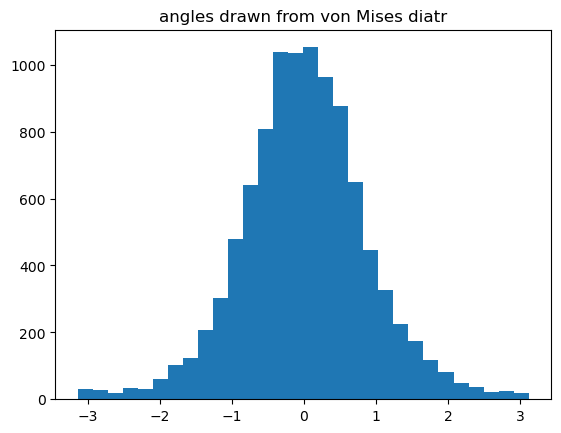

In [52]:
data = np.random.vonmises(0.0,2,size=10_000)
plt.hist(data,bins=30)
plt.title('angles drawn from von Mises diatr');

In [53]:
# TESTING DIFFS
x = np.array([1,0,0])
y = np.array([0,1,0])

u = np.array([1,0,0])
v = np.array([0,1,0])

z = 1 + 2j

x_prime,y_prime = invPsi(Psi((x,y)))
print(f'{x_prime - x = }')
print(f'{y_prime - y = }')

w = Psi(invPsi(z))
print(f'{w - z = }')

x_prime - x = array([0., 0., 0.])
y_prime - y = array([0., 0., 0.])
w - z = 0j
